In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import tabulate
import requests
from bs4 import BeautifulSoup,Comment
import re
import ast
import math
from urllib.parse import urljoin
from datetime import datetime
import time
from urllib.request import urlopen
from fpdf import FPDF
from common.removeBackground import removeBackground
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from PIL import Image
from io import BytesIO
import os
import tempfile
import ollama
from mplsoccer import PyPizza, add_image, FontManager, Radar, grid
import LanusStats as ls
fbref = ls.Fbref()
import random



In [2]:
def extract_player_info(url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extraer información básica
        player_info = {}
        
        # Intentamos primero extraer el nombre del jugador de <h1><span>
        player_name = soup.find('h1').find('span')
        if player_name:
            player_info['Player'] = player_name.text.strip()
        else:
            # Si no encontramos el nombre en <h1><span>, buscamos el primer <strong> dentro de <p>
            strong_name = soup.find('p').find('strong')
            if strong_name:
                player_info['Player'] = strong_name.text.strip()
            else:
                player_info['Player'] = 'Nombre no encontrado'  # Valor por defecto si no se encuentra el nombre

        # Extraer la posición del jugador
        position_element = soup.select_one('p:-soup-contains("Position")')
        if position_element:
            player_info['Position'] = position_element.text.split(':')[1].split(' ')[0].strip()
        else:
            player_info['Position'] = 'Posición no encontrada'

    # Extraer el equipo del jugador
        paragraphs = soup.find_all('p')
        player_team = None
        # Recorremos todos los párrafos
        for p in paragraphs:
        # Verificamos si el párrafo contiene el texto 'Club :'
            if 'Club:' in p.text:
            # Encontramos el enlace dentro del párrafo
                player_team = p.find('a').text.strip()
                break
        player_info['Team'] = player_team if player_team else 'Equipo no encontrado'

        # Extraer la fecha de nacimiento y calcular la edad
        birthday = soup.select_one('span[id="necro-birth"]')
        if birthday:
            birthday = birthday.text.strip()
            player_info['Age'] = (datetime.now() - datetime.strptime(birthday, '%B %d, %Y')).days // 365
        else:
            player_info['Age'] = 'Edad no encontrada'

        # Extraer la URL de la imagen del jugador
        media_item_div = soup.find('div', class_='media-item')  # Verificar si el div existe
        if media_item_div:  # Si el div existe, buscar el tag <img>
            img_tag = media_item_div.find('img')
            if img_tag and 'src' in img_tag.attrs:  # Verificar si el <img> existe y tiene el atributo 'src'
                player_info['Photo_URL'] = img_tag['src']
            else:
                player_info['Photo_URL'] = ""  # Si no hay <img> o no tiene 'src'
        else:
            player_info['Photo_URL'] = "No encontrada"  # Si no hay div con la clase 'media-item'

        return player_info 


In [54]:
url= 'https://fbref.com/en/players/50f7c408/Lucas-Acosta'

In [55]:
player_info = extract_player_info(url)
player_info

{'Player': 'Lucas Acosta',
 'Position': 'GK',
 'Team': 'Sarmiento',
 'Age': 29,
 'Photo_URL': 'https://fbref.com/req/202302030/images/headshots/50f7c408_2022.jpg'}

In [6]:
# Nueva función para mostrar ligas disponibles
def get_available_leagues():
    """
    Devuelve las ligas disponibles y sus temporadas.

    Returns:
        dict: Diccionario de ligas y temporadas disponibles.
    """
    
    possible_leagues = {
        'Fbref': {
            'Primera Division Argentina': {
                'id': 21,
                'slug': 'Primera-Division',
                'seasons': ['2025','2024', '2023']
            }
        }}

    # Formatear datos de ligas y temporadas en un diccionario legible
    available_leagues = {}
    for league_name, league_data in possible_leagues['Fbref'].items():
        available_leagues[league_name] = {
            'id': league_data['id'],
            'seasons': league_data['seasons']
        } 
    return available_leagues

leagues = get_available_leagues()

In [7]:
# Diccionario de tablas disponibles (Big-5 como referencia, puedes expandirlo)
TABLES = {
    "players": {
        "Standard Stats": "stats/players",
        "Shooting": "shooting/players",
        "Playing Time": "playingtime/players",
        "Miscellaneous Stats": "misc/players",
    },
    "squads": {
        "Standard Stats": "stats/squads",
        "Shooting": "shooting/squads",
        "Playing Time": "playingtime/squads",
        "Miscellaneous Stats": "misc/squads",
    }
}

# Función para generar URLs
def generate_all_urls(TABLES):
    """
    Genera todas las combinaciones posibles de URLs para las estadísticas disponibles,
    tanto para ligas individuales como para el Big-5, incluyendo temporadas específicas.

    Returns:
        dict: Un diccionario con las URLs organizadas por liga, temporada, y tipo de estadística.
    """
    # Obtener las ligas disponibles y sus temporadas
    available_leagues = get_available_leagues()

    # URL base
    base_url = "https://fbref.com/en/comps/"

    # Diccionario para almacenar las URLs generadas
    urls = {}

    # Iterar por las ligas y sus temporadas
    for league_name, league_data in available_leagues.items():
        league_id = league_data["id"]
        league_urls = {}

        for season in league_data["seasons"]:
            season_urls = {"players": {}, "squads": {}}

            # Generar URLs para jugadores (players)
            for stat, path in TABLES['players'].items():
                season_urls["players"][stat] = (
                    f"{base_url}{league_id}/{path}/{season}/{league_name.replace(' ', '-')}-Stats"
                )

            # Generar URLs para equipos (squads)
            for stat, path in TABLES['squads'].items():
                season_urls["squads"][stat] = (
                    f"{base_url}{league_id}/{path}/{season}/{league_name.replace(' ', '-')}-Stats"
                )

            # Añadir las URLs de esta temporada al diccionario de la liga
            league_urls[season] = season_urls

        # Añadir las URLs de la liga al diccionario principal
        urls[league_name] = league_urls

    return urls

# Generar URLs
all_urls = generate_all_urls(TABLES)


In [28]:
def format_dataframe_columns(df, stat_category):
    """
    Reformatea las columnas de un DataFrame eliminando los niveles de índice,
    añadiendo un sufijo basado en la estadística y asegurando nombres únicos.

    Args:
        df (pd.DataFrame): El DataFrame original con columnas multinivel o repetidas.
        stat_category (str): La estadística que se añadirá como sufijo a las columnas.

    Returns:
        pd.DataFrame: El DataFrame con columnas reformateadas y sin duplicados.
    """
    # Si las columnas tienen un índice multinivel
    if isinstance(df.columns, pd.MultiIndex):
        # Convertir el índice multinivel a un solo nivel
        df.columns = [f"{col[1]} ({col[0]} - {stat_category})" for col in df.columns]
    else:
        # Si no es multinivel, simplemente añade el sufijo de la estadística
        df.columns = [f"{col} ({stat_category})" for col in df.columns]

    # Asegurar nombres únicos en caso de duplicados
    seen = {}
    new_columns = []
    
    for col in df.columns:
        if col in seen:
            seen[col] += 1
            new_columns.append(f"{col}_{seen[col]}")  # Agregar sufijo incremental
        else:
            seen[col] = 0
            new_columns.append(col)

    df.columns = new_columns  # Asignar los nuevos nombres únicos

    return df


In [14]:
def scrape_stats_player(league ='Primera Division Argentina', season= '2025',stat= 'Standard Stats',team_type="players"):
    
     # Accedemos al diccionario de URLs
    league_data = all_urls[league]
        
    # Verificamos si la temporada existe en la liga
    if season not in league_data:
        raise ValueError(f"La temporada '{season}' no está disponible para la liga '{league}'.")
        
    # Determinamos el tipo de equipo según el team_type
    if team_type == "teams":
        if league == "Big 5 European Leagues":
            team_type = "squads"
        else:
            team_type = "players"

    # Accedemos a las URLs de la temporada
    season_data = league_data[season]

    # Verificamos si la estadística solicitada existe en el tipo de equipo
    if stat not in season_data[team_type]:
        raise ValueError(f"La estadística '{stat}' no está disponible para '{team_type}' en la liga '{league}'.")
        
    # Devolvemos la URL correspondiente
    return season_data[team_type][stat]

In [31]:
def extract_tables(league='Primera Division Argentina', season= '2025', stat='Standard Stats', team_type="players", save_excel=False):
    """
    Extrae las tablas de una página web dependiendo de si la URL contiene 'Big5' utilizando pandas.read_html.

    Args:
        league (str): Liga que se desea extraer (ejemplo: 'Big 5 European Leagues').
        season (str): Temporada específica.
        stat (str): Tipo de estadística.
        team_type (str): Tipo de datos ('players', 'teams', etc.).

    Returns:
        list: Una lista de pandas DataFrames con las tablas extraídas.
    """
    # Obtener la URL usando la función `scrape_stats_player`
    # Obtener la URL usando la función `scrape_stats_player`
    try:
        url = scrape_stats_player(league, season, stat, team_type)
        print(f"URL generada: {url}")
    except Exception as e:
        print(f"Error al obtener la URL: {e}")
        return []
    
    # Intentar leer las tablas visibles con pandas.read_html
    try:
        tables = pd.read_html(url)
        
        # Si la URL contiene "Big5", devolver solo la primera tabla
        if "Big5" in url:
            print(f"Starting to scrape player data for {stat} from FBREF...")
            if tables:
                table0 = tables[0].fillna(0)
                # Reformatear las columnas del DataFrame
                table0 = format_dataframe_columns(table0, stat)
                table0 = table0[table0.iloc[:, 0] != 'Rk'].reset_index(drop=True)
                # Filtrar columnas que no contengan 'matches' en su nombre
                table0 = table0.loc[:, ~table0.columns.str.contains('matches', case=False)]
                
        
                # Identificar la columna que contiene "Nation" y procesarla
                for col in table0.columns[table0.columns.str.contains("Nation")]:
                    table0[col] = table0[col].str.extract(r'([A-Z]+)$')
                
                # Identificar la columna que contiene "Age" y procesarla
                for col in table0.columns[table0.columns.str.contains("Age")]:
                    # Quedarnos solo con la parte antes del guion
                    table0[col] = table0[col].str.split('-').str[0]  # Alternativa usando str.extract: table0[col] = table0[col].str.extract(r'(\d+)-')
                
                # Identificar la columna que contiene "Comp" y procesarla
                for col in table0.columns[table0.columns.str.contains("Comp")]:
                    # Quedarnos con la parte después del primer espacio
                    table0[col]= table0[col].str.extract(r'\s(.+)')
                return table0
        else:
            print("La URL no contiene 'Big5'. Se procederá con BeautifulSoup.")
            print(f"Starting to scrape player data for {stat} from FBREF...")
    except Exception as e:
        print(f"Error al leer tablas con pandas.read_html: {e}")
    
    # Si no es Big5 o pandas.read_html falla, usar BeautifulSoup
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Extraer tablas dentro de comentarios
        comment = soup.find_all(string=lambda t: isinstance(t, Comment))
        comment_table = None
        for comment_item in comment:
            if '<div class="table_container"' in comment_item:
                comment_table = comment_item
                break
        
        if not comment_table:
            raise ValueError("No se encontró ninguna tabla dentro de comentarios.")
        
        # Parsear el comentario como HTML y extraer la tabla
        comment_html = BeautifulSoup(comment_table, 'html.parser')
        table = comment_html.find('table')
        if not table:
            raise ValueError("No se encontró ninguna tabla en el HTML del comentario.")
        
        # Extraer cabeceras y datos
        headings = [th.get_text() for th in table.find_all("th", scope="col")]
        data = []
        rows = table.find('tbody').find_all('tr')
        for row in rows:
            cols = [td.get_text(strip=True) for td in row.find_all(['th', 'td'])]
            data.append(cols)
        
        # Crear el DataFrame
        df_data = pd.DataFrame(data, columns=headings)

    
        df_data = df_data.fillna(0).reset_index(drop=True)
        
        # Si no es Big5, agregar columna 'Comp'
        if league != 'Big 5 European Leagues':
            df_data.insert(4, 'Comp', [league] * len(df_data))
        
                            
        # Reformatear las columnas del DataFrame
        df = format_dataframe_columns(df_data, stat)
        df = df[df.iloc[:, 0] != 'Rk'].reset_index(drop=True)
        # Filtrar columnas que no contengan 'matches' en su nombre
        df = df.loc[:, ~df.columns.str.contains('matches', case=False)]
        df = df.loc[:, ~df.columns.str.contains('Rk', case=False)]
        
        # Identificar la columna que contiene "Nation" y procesarla
        for col in df.columns[df.columns.str.contains("Nation")]:
            df[col] = df[col].str.extract(r'([A-Z]+)$')
        
        # Identificar la columna que contiene "Age" y procesarla
        for col in df.columns[df.columns.str.contains("Age")]:
            # Quedarnos solo con la parte antes del guion
            df[col] = df[col].str.split('-').str[0]  # Alternativa usando str.extract: df[col] = df[col].str.extract(r'(\d+)-')

        if save_excel:
              df.to_excel(f'{league} - {season} - {stat} - player stats.xlsx')
              
        return df
    except Exception as e:
        print(f"Error al procesar la tabla con BeautifulSoup: {e}")

In [39]:
df_misc =extract_tables(league='Primera Division Argentina', season= '2025', stat='Miscellaneous Stats', team_type="players", save_excel=False)
df_misc

URL generada: https://fbref.com/en/comps/21/misc/players/2025/Primera-Division-Argentina-Stats
Error al leer tablas con pandas.read_html: HTTP Error 524: 


,Player (Miscellaneous Stats),Nation (Miscellaneous Stats),Pos (Miscellaneous Stats),Comp (Miscellaneous Stats),Squad (Miscellaneous Stats),Age (Miscellaneous Stats),Born (Miscellaneous Stats),90s (Miscellaneous Stats),CrdY (Miscellaneous Stats),CrdR (Miscellaneous Stats),2CrdY (Miscellaneous Stats),Fls (Miscellaneous Stats),Fld (Miscellaneous Stats),Off (Miscellaneous Stats),Crs (Miscellaneous Stats),Int (Miscellaneous Stats),TklW (Miscellaneous Stats),PKwon (Miscellaneous Stats),PKcon (Miscellaneous Stats),OG (Miscellaneous Stats)
0,Lucas Abascia,ARG,DF,Primera Division Argentina,Cen. Córdoba–SdE,29,1995,0.7,0,0,0,0,0,0,0,2,2,,,0
1,Ignacio Abraham,SYR,DF,Primera Division Argentina,Banfield,27,1998,0.1,0,0,0,0,0,0,0,0,0,,,0
2,Gonzalo Abrego,ARG,MF,Primera Division Argentina,Godoy Cruz,25,2000,0.7,0,0,0,1,0,0,1,0,0,,,0
3,Jonás Acevedo,ARG,MF,Primera Division Argentina,Instituto,28,1997,1.1,0,0,0,0,0,2,6,0,1,,,0
4,Guillermo Acosta,ARG,MF,Primera Division Argentina,Atlé Tucumán,36,1988,3.1,0,0,0,1,1,0,4,5,5,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Exequiel Zeballos,ARG,"MF,FW",Primera Division Argentina,Boca Juniors,22,2002,2.9,1,0,0,2,2,4,9,0,2,,,0
632,Lucas Zelarayán,ARM,"MF,FW",Primera Division Argentina,Belgrano,32,1992,2.3,0,0,0,1,9,1,22,0,1,,,0
633,Felipe Zenobio,ARG,GK,Primera Division Argentina,Tigre,24,2000,5.0,0,0,0,0,1,0,0,0,0,,,0
634,Kevin Zenon,ARG,MF,Primera Division Argentina,Boca Juniors,23,2001,0.6,0,1,0,1,2,0,1,0,1,,,0


In [41]:
def formatear_datos(df):
    mapeo_columns= {
    'Player (Standard Stats)':'Player',
    'Nation (Standard Stats)':'Nacionalidad',
    'Pos (Standard Stats)':'Posicion', 'Comp (Standard Stats)':'Competicion',
    'Squad (Standard Stats)':'Equipo','Age (Standard Stats)':'Edad',
    'Born (Standard Stats)':'Año', 'MP (Standard Stats)':'Partidos jugados',
    'Starts (Standard Stats)':'Alineaciones', 'Min (Standard Stats)':'Minutos jugados',
    '90s (Standard Stats)':'Minutos jugados/90',  'Gls (Standard Stats)':'Goles', 'Ast (Standard Stats)':'Asistencias',
    'G+A (Standard Stats)':'Goles + Asistencias', 'G-PK (Standard Stats)': 'Goles sin penalización', 'PK (Standard Stats)':'Tiros penales ejecutados',
    'PKatt (Standard Stats)':'Tiros penales intentados','CrdY (Standard Stats)':'Tarjetas amarillas',
     'CrdR (Standard Stats)':'Tarjetas rojas', 'Gls (Standard Stats)_1':'Goles/90', 'Ast (Standard Stats)_1':'Asistencias/90',
    'G+A (Standard Stats)_1':'Goles + Asistencias/90', 'G-PK (Standard Stats)_1':'Goles sin penalizacion/90',
    'G+A-PK (Standard Stats)':'Goles + Asistencias sin penalizacion/90', 

    'Player (Shooting)':'Player',
    'Nation (Shooting)':'Nacionalidad', 'Pos (Shooting)':'Posicion',
    'Comp (Shooting)':'Competicion', 'Squad (Shooting)': 'Equipo',  'Age (Shooting)':'Edad',
    'Born (Shooting)':'Año','90s (Shooting)':'Minutos jugados/90',  'Gls (Shooting)':'Goles',  'Sh (Shooting)': 'Total de disparos',
    'SoT (Shooting)':'Lanzamientos en el Objetivo', 'SoT% (Shooting)':'Lanzaminetos en el Objetivo %','Sh/90 (Shooting)':'Tiros totales/90',
    'SoT/90 (Shooting)':'Tiros a puerta/90', 'G/Sh (Shooting)':'Goles/tiros', 'G/SoT (Shooting)': 'Gols/Disparo en el Objetivo',
     'Dist (Shooting)':'Distancia media de disparo','PK (Shooting)':'Tiros penales ejecutados', 'PKatt (Shooting)':'Tiros penales intentados',
 
    'Player (Miscellaneous Stats)':'Player','Nation (Miscellaneous Stats)':'Nacionalidad',
    'Pos (Miscellaneous Stats)':'Posicion',  'Comp (Miscellaneous Stats)':'Competicion',
    'Squad (Miscellaneous Stats)':'Equipo', 'Age (Miscellaneous Stats)':'Edad',
'Born (Miscellaneous Stats)':'Año', '90s (Miscellaneous Stats)':'Minutos jugados/90',
    'CrdY (Miscellaneous Stats)':'Tarjetas amarillas', 'CrdR (Miscellaneous Stats)':'Tarjetas rojas',
    '2CrdY (Miscellaneous Stats)':'Segunda tarjeta amarilla', 'Fls (Miscellaneous Stats)':'Faltas cometidas',
    'Fld (Miscellaneous Stats)':'Faltas recibidas','Off (Miscellaneous Stats)': 'Posicion adelantada',
    'Crs (Miscellaneous Stats)': 'Pases cruzados', 'Int (Miscellaneous Stats)':'Intercepciones',
    'TklW (Miscellaneous Stats)':'Derribos conseguidos', 'PKwon (Miscellaneous Stats)':'Penaltis ejecutados',
   'PKcon (Miscellaneous Stats)':'Penaltis concedidos', 'OG (Miscellaneous Stats)':'Goles en propia',
       
        }
    df_cambio = df.rename(columns=mapeo_columns)
    df_cambio = df_cambio.loc[:, ~df_cambio.columns.duplicated(keep='first')]
    df_cambio["Nacionalidad"] = (df_cambio[["Nacionalidad"]].squeeze().astype(str).str.extract(r'([A-Z]{3})$')[0])

    df_cambio["Edad"] = (df_cambio[["Edad"]].squeeze().astype(str).str.split('-').str[0])

    return df_cambio

In [42]:
def all_stats_player(stat= ['Standard Stats','Shooting','Miscellaneous Stats'], league= 'Primera Division Argentina',season= '2025',add_page_name=True):

    df_stats =extract_tables(league='Primera Division Argentina', season= '2025', stat='Standard Stats', team_type="players", save_excel=False)
    time.sleep(random.uniform(2, 5))

    df_shooting =extract_tables(league='Primera Division Argentina', season= '2025', stat='Shooting', team_type="players", save_excel=False)
    time.sleep(random.uniform(2, 5))

    df_misc =extract_tables(league='Primera Division Argentina', season= '2025', stat='Miscellaneous Stats', team_type="players", save_excel=False)
    time.sleep(random.uniform(2, 5))


    df_general_final= pd.concat([df_stats, df_shooting, df_misc], axis=1)

    df_general_final=df_general_final.fillna(0)
    df_general_jugadores_final= formatear_datos(df_general_final)
    return df_general_jugadores_final
    
df_general_jugadores_final= all_stats_player(stat= ['Standard Stats','Shooting','Miscellaneous Stats'], league= 'Primera Division Argentina', season= '2025',add_page_name=True)

URL generada: https://fbref.com/en/comps/21/stats/players/2025/Primera-Division-Argentina-Stats
La URL no contiene 'Big5'. Se procederá con BeautifulSoup.
Starting to scrape player data for Standard Stats from FBREF...
URL generada: https://fbref.com/en/comps/21/shooting/players/2025/Primera-Division-Argentina-Stats
La URL no contiene 'Big5'. Se procederá con BeautifulSoup.
Starting to scrape player data for Shooting from FBREF...
URL generada: https://fbref.com/en/comps/21/misc/players/2025/Primera-Division-Argentina-Stats
La URL no contiene 'Big5'. Se procederá con BeautifulSoup.
Starting to scrape player data for Miscellaneous Stats from FBREF...


In [13]:
df_general_jugadores_final

,Player,Nacionalidad,Posicion,Equipo,Competicion,Edad,Año,Partidos jugados,Alineaciones,Minutos jugados,...,Segunda tarjeta amarilla,Faltas cometidas,Faltas recibidas,Posicion adelantada,Pases cruzados,Intercepciones,Derribos conseguidos,Penaltis ejecutados,Penaltis concedidos,Goles en propia
0,Ignacio Abraham,SYR,DF,Banfield,Primera Division Argentina,27,1998,1,0,11,...,0,0,0,0,0,0,0,0.0,0.0,0
1,Gonzalo Abrego,ARG,MF,Godoy Cruz,Primera Division Argentina,25,2000,2,1,62,...,0,1,0,0,1,0,0,0.0,0.0,0
2,Jonás Acevedo,ARG,MF,Instituto,Primera Division Argentina,28,1997,4,0,103,...,0,0,0,2,6,0,1,0.0,0.0,0
3,Guillermo Acosta,ARG,MF,Atlé Tucumán,Primera Division Argentina,36,1988,4,3,275,...,0,1,1,0,4,5,5,0.0,0.0,0
4,Lautaro Acosta,ARG,"FW,MF",Lanús,Primera Division Argentina,36,1988,2,0,21,...,0,0,2,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Exequiel Zeballos,ARG,"MF,FW",Boca Juniors,Primera Division Argentina,22,2002,4,3,232,...,0,2,2,4,9,0,2,0.0,0.0,0
624,Lucas Zelarayán,ARM,"MF,FW",Belgrano,Primera Division Argentina,32,1992,3,3,206,...,0,1,9,1,22,0,1,0.0,0.0,0
625,Felipe Zenobio,ARG,GK,Tigre,Primera Division Argentina,24,2000,4,4,360,...,0,0,1,0,0,0,0,0.0,0.0,0
626,Kevin Zenon,ARG,MF,Boca Juniors,Primera Division Argentina,23,2001,3,0,53,...,0,1,2,0,1,0,1,0.0,0.0,0


In [52]:
def df_jugadores_interes(df):
    columnas_interes_jugadores= ['Player', 'Nacionalidad', 'Posicion', 'Equipo', 'Competicion', 'Edad', 'Año', 'Minutos jugados', 'Minutos jugados/90', 'Partidos jugados',
                              'Alineaciones','Goles/90', 'Asistencias/90','Goles + Asistencias sin penalizacion/90', 'Derribos conseguidos', 
                                'Intercepciones','Tiros totales/90', 'Tiros a puerta/90', 'Goles/tiros']

    df_jugadores_final = df_general_jugadores_final[columnas_interes_jugadores]
    return df_jugadores_final

df_jugadores_final= df_jugadores_interes(df_general_jugadores_final)
df_jugadores_final

,Player,Nacionalidad,Posicion,Equipo,Competicion,Edad,Año,Minutos jugados,Minutos jugados/90,Partidos jugados,Alineaciones,Goles/90,Asistencias/90,Goles + Asistencias sin penalizacion/90,Derribos conseguidos,Intercepciones,Tiros totales/90,Tiros a puerta/90,Goles/tiros
0,Lucas Abascia,ARG,DF,Cen. Córdoba–SdE,Primera Division Argentina,29,1995,59,0.7,1,1,0.00,0.00,0.00,2,2,1.53,0.00,0.00
1,Ignacio Abraham,SYR,DF,Banfield,Primera Division Argentina,27,1998,11,0.1,1,0,0.00,0.00,0.00,0,0,0.00,0.00,
2,Gonzalo Abrego,ARG,MF,Godoy Cruz,Primera Division Argentina,25,2000,62,0.7,2,1,0.00,0.00,0.00,0,0,1.45,0.00,0.00
3,Jonás Acevedo,ARG,MF,Instituto,Primera Division Argentina,28,1997,103,1.1,4,0,0.87,0.00,0.87,1,0,2.62,0.87,0.33
4,Guillermo Acosta,ARG,MF,Atlé Tucumán,Primera Division Argentina,36,1988,275,3.1,4,3,0.00,0.00,0.00,5,5,0.33,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Exequiel Zeballos,ARG,"MF,FW",Boca Juniors,Primera Division Argentina,22,2002,258,2.9,5,3,0.35,0.00,0.35,2,0,2.09,0.70,0.17
632,Lucas Zelarayán,ARM,"MF,FW",Belgrano,Primera Division Argentina,32,1992,206,2.3,3,3,0.00,0.00,0.00,1,0,2.62,0.87,0.00
633,Felipe Zenobio,ARG,GK,Tigre,Primera Division Argentina,24,2000,450,5.0,5,5,0.00,0.00,0.00,0,0,0.00,0.00,
634,Kevin Zenon,ARG,MF,Boca Juniors,Primera Division Argentina,23,2001,53,0.6,3,0,0.00,0.00,0.00,1,0,3.40,3.40,0.00


In [53]:
def transformacion_90(df):
    df["Derribos conseguidos"] = pd.to_numeric(df["Derribos conseguidos"], errors="coerce")
    df["Intercepciones"] = pd.to_numeric(df["Intercepciones"], errors="coerce")
    df["Minutos jugados/90"] = pd.to_numeric(df["Minutos jugados/90"], errors="coerce")

    # Asegúrate de que no haya valores nulos o ceros en 'Minutos jugados/90' para evitar divisiones por cero
    df["Derribos conseguidos/90"] = df["Derribos conseguidos"] / df["Minutos jugados/90"]
    df["Intercepciones/90"] = df["Intercepciones"] / df["Minutos jugados/90"]

    df["Derribos conseguidos/90"] = df["Derribos conseguidos/90"].round(2)
    df["Intercepciones/90"] = df["Intercepciones/90"].round(2)

    df = df.drop(columns= ['Derribos conseguidos', 'Intercepciones'] )
    df= df.fillna(0)
    df = df.replace(r'^\s*$', 0, regex=True)  # Reemplaza espacios vacíos con 0



    return df

df_jugadores_final= transformacion_90(df_jugadores_final)
df_jugadores_final

,Player,Nacionalidad,Posicion,Equipo,Competicion,Edad,Año,Minutos jugados,Minutos jugados/90,Partidos jugados,Alineaciones,Goles/90,Asistencias/90,Goles + Asistencias sin penalizacion/90,Tiros totales/90,Tiros a puerta/90,Goles/tiros,Derribos conseguidos/90,Intercepciones/90
0,Lucas Abascia,ARG,DF,Cen. Córdoba–SdE,Primera Division Argentina,29,1995,59,0.7,1,1,0.00,0.00,0.00,1.53,0.00,0.00,2.86,2.86
1,Ignacio Abraham,SYR,DF,Banfield,Primera Division Argentina,27,1998,11,0.1,1,0,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00
2,Gonzalo Abrego,ARG,MF,Godoy Cruz,Primera Division Argentina,25,2000,62,0.7,2,1,0.00,0.00,0.00,1.45,0.00,0.00,0.00,0.00
3,Jonás Acevedo,ARG,MF,Instituto,Primera Division Argentina,28,1997,103,1.1,4,0,0.87,0.00,0.87,2.62,0.87,0.33,0.91,0.00
4,Guillermo Acosta,ARG,MF,Atlé Tucumán,Primera Division Argentina,36,1988,275,3.1,4,3,0.00,0.00,0.00,0.33,0.00,0.00,1.61,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Exequiel Zeballos,ARG,"MF,FW",Boca Juniors,Primera Division Argentina,22,2002,258,2.9,5,3,0.35,0.00,0.35,2.09,0.70,0.17,0.69,0.00
632,Lucas Zelarayán,ARM,"MF,FW",Belgrano,Primera Division Argentina,32,1992,206,2.3,3,3,0.00,0.00,0.00,2.62,0.87,0.00,0.43,0.00
633,Felipe Zenobio,ARG,GK,Tigre,Primera Division Argentina,24,2000,450,5.0,5,5,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00
634,Kevin Zenon,ARG,MF,Boca Juniors,Primera Division Argentina,23,2001,53,0.6,3,0,0.00,0.00,0.00,3.40,3.40,0.00,1.67,0.00


In [56]:
minutos_totales= int(df_jugadores_final['Partidos jugados'].max())*90

player_info['Minutos totales jugados liga']= minutos_totales


In [57]:
def creacion_valores_liga(df):
    df_jugadores_90_sincolumnas = df.drop(columns=['Player','Nacionalidad',	'Posicion','Equipo','Competicion','Edad','Año','Minutos jugados','Minutos jugados/90'])
    df_jugadores_90_sincolumnas = df_jugadores_90_sincolumnas.apply(pd.to_numeric, errors="coerce")
    media_columnas = df_jugadores_90_sincolumnas.mean()
    df_media_columnas_jugadores = media_columnas.to_frame().reset_index()
    df_media_columnas_jugadores.columns = ['Estadistica', 'Media']
    df_media_columnas_jugadores= df_media_columnas_jugadores.round(2)
    player_info['Valores_media_liga']= df_media_columnas_jugadores
    return df_media_columnas_jugadores
df_media_columnas_jugadores = creacion_valores_liga(df_jugadores_final)
df_media_columnas_jugadores

,Estadistica,Media
0,Partidos jugados,3.17
1,Alineaciones,2.21
2,Goles/90,0.08
3,Asistencias/90,0.10
4,Goles + Asistencias sin penalizacion/90,0.17
5,Tiros totales/90,1.14
6,Tiros a puerta/90,0.38
7,Goles/tiros,0.05
8,Derribos conseguidos/90,1.19
9,Intercepciones/90,0.85


MATRICAS MEDIA LIGA

In [58]:
values_liga_jugadores = df_media_columnas_jugadores['Media'].to_list()
values_liga = pd.to_numeric(values_liga_jugadores, errors="coerce")
values_liga

array([3.17, 2.21, 0.08, 0.1 , 0.17, 1.14, 0.38, 0.05, 1.19, 0.85])

METRICAS POR 90 JUGADOR

In [59]:
def obtener_df_jugador_interes(player_info):
    fila_jugador = df_jugadores_final.loc[df_jugadores_final['Player']== player_info['Player']].reset_index(drop=True)

    return fila_jugador

fila_jugador= obtener_df_jugador_interes(player_info)
fila_jugador

,Player,Nacionalidad,Posicion,Equipo,Competicion,Edad,Año,Minutos jugados,Minutos jugados/90,Partidos jugados,Alineaciones,Goles/90,Asistencias/90,Goles + Asistencias sin penalizacion/90,Tiros totales/90,Tiros a puerta/90,Goles/tiros,Derribos conseguidos/90,Intercepciones/90
0,Lucas Acosta,ARG,GK,Sarmiento,Primera Division Argentina,29,1995,360,4.0,4,4,0.00,0.00,0.00,0.00,0.00,0,0.0,0.0


In [60]:
def extraer_metricas_jugador(player_info):

    columnas_interes_jugadores= [ 'Partidos jugados',    'Alineaciones','Goles/90', 'Asistencias/90','Goles + Asistencias sin penalizacion/90', 'Tiros totales/90', 'Tiros a puerta/90',
                                  'Goles/tiros','Derribos conseguidos/90', 
                                'Intercepciones/90']
    # Crear un DataFrame en el formato deseado
    tabla_metricas90 = pd.DataFrame({
            "Estadística": columnas_interes_jugadores,
            "Por 90": fila_jugador.loc[:, columnas_interes_jugadores].values.flatten()})

    player_info['Tabla metricas']= tabla_metricas90
    return player_info
player_info= extraer_metricas_jugador(player_info)

In [61]:
player_info= extraer_metricas_jugador(player_info)
player_info

{'Player': 'Lucas Acosta',
 'Position': 'GK',
 'Team': 'Sarmiento',
 'Age': 29,
 'Photo_URL': 'https://fbref.com/req/202302030/images/headshots/50f7c408_2022.jpg',
 'Minutos totales jugados liga': 450,
 'Valores_media_liga':                                Estadistica  Media
 0                         Partidos jugados   3.17
 1                             Alineaciones   2.21
 2                                 Goles/90   0.08
 3                           Asistencias/90   0.10
 4  Goles + Asistencias sin penalizacion/90   0.17
 5                         Tiros totales/90   1.14
 6                        Tiros a puerta/90   0.38
 7                              Goles/tiros   0.05
 8                  Derribos conseguidos/90   1.19
 9                        Intercepciones/90   0.85,
 'Tabla metricas':                                Estadística Por 90
 0                         Partidos jugados      4
 1                             Alineaciones      4
 2                                 Goles/90

In [62]:
def extraer_variables_radar(player_info):
    params= player_info['Tabla metricas'].Estadística.to_list()
    values_jugador= player_info['Tabla metricas']['Por 90'].to_list()
    values_jugador = pd.to_numeric(values_jugador, errors="coerce")
    return params, values_jugador

params, values_jugador= extraer_variables_radar(player_info)

RADAR COMPARTAIVO JUGADOR VS AVERAGE LEAGUE

In [63]:
def rangos_radar_pizza(values_jugador, values_liga, params):
    

    # Asegurarnos de que las estructuras sean listas
    values_jugador = values_jugador.tolist() if isinstance(values_jugador, pd.Series) else values_jugador
    values_liga = values_liga.tolist() if isinstance(values_liga, pd.Series) else values_liga

    # Verificar que las listas tengan la misma longitud
    if len(params) == len(values_jugador) == len(values_liga):
        
        # Crear listas dinámicamente para min_range y max_range con márgenes ajustados
        min_range = []
        max_range = []

        colchon_min = 1  # Colchón inferior
        colchon_max =1  # Colchón superior

        for index, param in enumerate(params):  # Iterar usando el índice directamente
            try:
                # Valores de jugador y liga
                jugador_value = float(values_jugador[index])
                liga_value = float(values_liga[index])
                
                # Cálculo de mínimo y máximo
                min_value = min(jugador_value, liga_value)
                max_value = max(jugador_value, liga_value)
                
                # Ajustar los valores respetando el colchón
                min_value_adjusted = max(0, math.floor(min_value) - colchon_min)  # Mínimo con colchón inferior
                max_value_adjusted = math.ceil(max_value) + colchon_max  # Máximo con colchón superior
                
                # Agregar valores a las listas
                min_range.append(min_value_adjusted)
                max_range.append(max_value_adjusted)
            except Exception as e:
                print(f"Error procesando el índice {index}: {e}")
                min_range.append(None)
                max_range.append(None)

    else:
        raise ValueError("Las listas `params`, `values_jugador` y `values_liga` deben tener la misma longitud.")# Verificar si las longitudes coinciden
    
    return min_range, max_range
min_range, max_range= rangos_radar_pizza(values_jugador, values_liga_jugadores, params)

In [24]:
especifico_a_general = {
    'GK': 'Porteros',

    'DF': 'Defensas',
    'DF (FB, right)':  'Defensas',
     'DF (FB, left)': 'Defensas',
     'DF-MF':  'Defensas',
     'DF-MF (FB, left)':  'Defensas',
     'DF-MF (FB, right)':  'Defensas',
     'DF-MF (CB-FB, right)': 'Defensas' ,
     'DF-MF (CB-FB, right)' :'Defensas' ,
     'DF-MF (CB-DM)':'Defensas',
     'DF (CB)':'Defensas',
     'DF (CB, left)':'Defensas' ,
     'DF (CB, right)':'Defensas' ,
     'DF (CB-FB)':'Defensas',
     'DF (CB-FB, right)': 'Defensas',
     'DF (CB-FB, left)':'Defensas',
     'DF-MF (FB-WM, right)':'Defensas',
    'DF-MF (FB-WM, left)':'Defensas',
    'DF-MF (DM)': 'Defensas',
    'DF-MF (AM-CM-WM)': 'Defensas',
    'DF-MF (CB)': 'Defensas',

    'MF': 'Centrocampistas',
    'MF (CM-WM)': 'Centrocampistas',
    'MF (CM-DM)': 'Centrocampistas',
    'DF-FW-MF (WM, right)':'Centrocampistas',
    'DF-FW-MF (WM, left)':'Centrocampistas',
    'MF (CM)':'Centrocampistas',
    'MF (AM)':'Centrocampistas',
    'MF (WM)':'Centrocampistas',
    'MF (CM, right)':'Centrocampistas',
    'MF (CM, left)':'Centrocampistas',
    'MF (WM, right)':'Centrocampistas',
    'MF (WM, left)':'Centrocampistas',
    'MF (DM)':'Centrocampistas',
    'MF (DM, left)':'Centrocampistas',
    'MF (AM-CM-WM)':'Centrocampistas',
    'MF (DM, right)':'Centrocampistas',
    'MF (CM-DM, right)':'Centrocampistas',
    'MF (CM-DM, left)':'Centrocampistas',
    'MF (AM-CM-DM-WM)':'Centrocampistas',

    'FW': 'Delanteros',
    'FW-MF': 'Delanteros',
    'DF-FW-MF (AM-WM)': 'Delanteros',
    'FW-MF (AM-WM)':'Delanteros',
    'FW-MF (AM)':'Delanteros',
    'FW-MF (AM, left)': 'Delanteros',
    'FW-MF (AM, right)':'Delanteros',
    'FW-MF (WM)':'Delanteros',
    'FW-MF (AM-CM-WM)':'Delanteros',
    'FW-MF (AM-WM)': 'Delanteros',
    'FW-MF (AM-WM, left)':'Delanteros',
    'FW-MF (AM-WM, right)':'Delanteros',
    'DF-FW-MF (CM-WM, left)': 'Delanteros'   

}
# Asumiendo que player_info['Position'] tiene el valor que indica la posición del jugador.
posicion_especifica = player_info['Position']
rol_general = especifico_a_general.get(posicion_especifica, 'Desconocido')  # Usamos el diccionario
player_info['Posicion general'] = rol_general

In [64]:
#FUENTES PARA LOS PERCENTILES
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

#FUENTES PARA LOS RADARES COMPARTIVOS
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

In [65]:
def generar_radar_pizza(player_info, temporada="2024-25", params=None, min_range=None, max_range=None, values_jugador=None, values_liga=None):
    # Comprobar que los argumentos necesarios no sean None
    if params is None or min_range is None or max_range is None or values_jugador is None or values_liga is None:
        raise ValueError("Los argumentos 'params', 'min_range', 'max_range', 'values_jugador' y 'values_liga' son obligatorios.")

    # instantiate PyPizza class
    baker = PyPizza(
        params=params,
        min_range=min_range,        # min range values
        max_range=max_range,        # max range values
        background_color="#323232", straight_line_color="#000000",
        last_circle_color="#000000", last_circle_lw=3, other_circle_lw=0,
        other_circle_color="#000000", straight_line_lw=1
    )

    # plot pizza
    fig, ax = baker.make_pizza(
        values_jugador,                     # list of values
        compare_values=values_liga,    # passing comparison values
        figsize=(9, 9),             # adjust figsize according to your need
        color_blank_space="same",   # use same color to fill blank space
        blank_alpha=0.4,            # alpha for blank-space colors
        param_location=109,         # where the parameters will be added
        kwargs_slices=dict(
            facecolor="#1A78CF", edgecolor="#000000",
            zorder=1, linewidth=1
        ),                          # values to be used when plotting slices
        kwargs_compare=dict(
            facecolor="#ff9300", edgecolor="#222222", zorder=3, linewidth=1,
        ),                          # values to be used when plotting comparison slices
        kwargs_params=dict(
            color="#F2F2F2", fontsize=10, zorder=5,
            fontproperties=font_normal.prop, va="center"
        ),                          # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=8,
            fontproperties=font_normal.prop, zorder=2,
            bbox=dict(
                edgecolor="#000000", facecolor="#1A78CF",
                boxstyle="round,pad=0.2", lw=1
            )
        ),                           # values to be used when adding parameter-values
        kwargs_compare_values=dict(
            color="#000000", fontsize=8,
            fontproperties=font_normal.prop, zorder=2,
            bbox=dict(
                edgecolor="#000000", facecolor="#FF9300",
                boxstyle="round,pad=0.1", lw=1
            )
        )                            # values to be used when adding comparison-values
    )

    # Definir los textos
    nombre_jugador = f"{player_info['Player']}"
    nombre_liga = "League Average"

    # add subtitle
    fig.text(
            0.515, 0.99,
            f"Estadísticas 90s vs Liga Profesional Argentina\nBasado en {player_info['Minutos totales jugados liga']} minutos jugados | Temporada: {temporada}",
            size=15,
            ha="center", fontproperties=font_bold.prop, color="#F2F2F2"
        )
    
        # add text for nombre_jugador
    fig.text(
        0.26, 0.95, f"{nombre_jugador}", size=14,  # Fija posición izquierda
        fontproperties=font_bold.prop, color="white", ha="left"
    )

    # add text for nombre_liga
    fig.text(
        0.83, 0.95, f"{nombre_liga}", size=14,  # Fija posición derecha
        fontproperties=font_bold.prop, color="white", ha="right"
    )

        # add rectangles
    fig.patches.extend([
            plt.Rectangle(
                (0.23, 0.95), 0.025, 0.021, fill=True, color="#1A78CF",
                transform=fig.transFigure, figure=fig
            ),
            
            plt.Rectangle(
                (0.63, 0.95), 0.025, 0.021, fill=True, color="#FF9300",
                transform=fig.transFigure, figure=fig
            ),
        ])
    plt.show()
    # Guardar la imagen después de crearla
    radar_img_path = "radar_jugador.png"
    fig.savefig(radar_img_path, bbox_inches="tight")
    plt.close(fig)  # Cerramos la figura para liberar memoria
    
    return radar_img_path


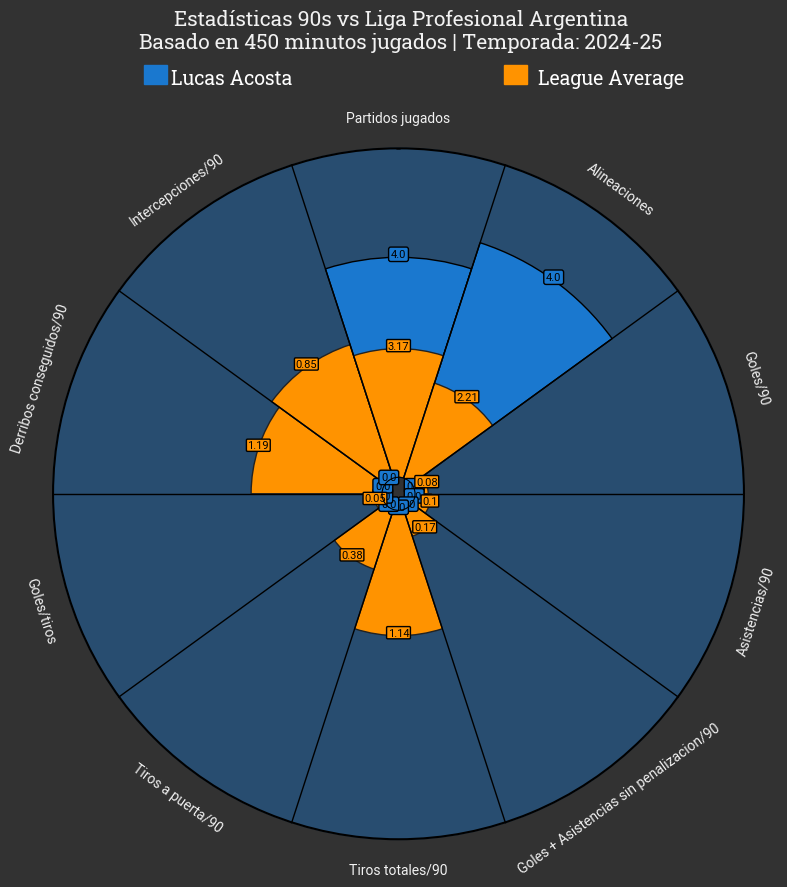

In [66]:
radar_img_path = generar_radar_pizza( player_info=player_info, temporada="2024-25", params=params, min_range=min_range, max_range=max_range,
                            values_jugador=values_jugador,  values_liga=values_liga)
    

APLICACIÓN IA

In [28]:
def generar_y_procesar_informe(player_info, modelo="llama3:8b"):
        """
        Genera un informe detallado sobre un jugador, usando el modelo de Ollama para procesar los datos.
        
        Args:
            player_data (dict): Diccionario con los datos del jugador. Debe incluir:
                - 'Player': Nombre del jugador
                - 'Position': Posición
                - 'Age': Edad
                - 'Team': Equipo actual
                - 'Similar_players': Tabla de jugadores similares (pandas DataFrame)
                - 'Tabla_metricas': Tabla de métricas avanzadas (pandas DataFrame)
            modelo (str): Nombre del modelo de Ollama. Por defecto es "llama3:8b".
            
        Returns:
            dict: Diccionario con las secciones del informe procesadas:
                - 'Resumen': Texto del resumen
                - 'Fortalezas': Lista de fortalezas
                - 'Debilidades': Lista de debilidades
                - 'Potencial': Texto del potencial
                - 'Jugadores Similares': Lista de jugadores similares
        """
        # Crear el prompt
        prompt_final = f"""
        Actúa como un scout de fútbol profesional con experiencia técnica y táctica.
        Necesito que crees un informe detallado sobre {player_info['Player']}, un jugador de {player_info['Position']} de {player_info['Age']} años que juega en {player_info['Team']}.
        Las secciones del informe serán: Resumen, Fortalezas, Debilidades y potencial.
        Basado en las estadísticas avanzadas de la tabla {player_info['Tabla metricas'].to_markdown()} y los datos de las medias de la liga en {player_info['Valores_media_liga'].to_markdown()},
        proporciona el informe con el siguiente formato:

        **Resumen**: Descripción breve del estilo de juego de {player_info['Player']} y su impacto en el campo.

        **Fortalezas**: En cada fortaleza añade la estadistica del per 90 y la media de la liga (Media liga:x). Siempre nombra una lista de 4 fortalezas.
        - Fortaleza 1
        - Fortaleza 2
        - Fortaleza 3
        - Fortaleza 4

        **Debilidades**: En cada debilidad añade la estadistica del per 90 y la media de la liga, ponerlo en formato (Media liga:x). Siempre nombra una lista de 4 debilidades.
        - Debilidad 1
        - Debilidad 2
        - Debilidad 3
        - Debilidad 4

        **Potencial**: Evaluación del potencial de desarrollo y áreas de mejora.

        """

        # Llamada al modelo de Ollama
        response = ollama.chat(model=modelo, messages=[{'role': 'user', 'content': prompt_final}])
        contenido = response.get('message', {}).get('content', "")
        if not contenido:
            raise ValueError("El modelo Ollama no devolvió una respuesta válida. Verifica la conexión o el prompt.")
        
        # Diccionario para almacenar las partes procesadas
        partes = {
            "Resumen": "",
            "Fortalezas": [],
            "Debilidades": [],
            "Potencial": ""
        }
        
        # Expresiones regulares para las secciones "Resumen" y "Potencial"
        secciones_regex = {
            "Resumen": r"\*\*Resumen\*\*:(.*?)(?=\*\*|$)",  # Captura todo después de **Resumen** hasta el siguiente encabezado
            "Potencial": r"\*\*Potencial\*\*:(.*?)(?=\*\*|$)"
        }
        # Extraer las secciones "Resumen" y "Potencial" usando regex
        for seccion, regex in secciones_regex.items():
            resultado = re.search(regex, contenido, re.DOTALL)  # .DOTALL permite que el punto capture saltos de línea
            if resultado:
                partes[seccion] = resultado.group(1).strip()  # Extraer y limpiar el contenido
                
        # Función auxiliar para extraer listas (Fortalezas, Debilidades y Jugadores Similares)
        def extraer_lista(texto):
            # Mejorar la captura para las listas numeradas
            items = re.findall(r"[\*\-]\s(.*?)(?=\n|$)", texto)  # Captura cualquier punto con * o - seguido de texto
            return [item.strip() for item in items if item.strip()]
        
        # Procesar las fortalezas, debilidades y jugadores similares
        if "**Fortalezas**" in contenido:
            fortalezas_texto = contenido.split("**Fortalezas**")[1].split("**Debilidades**")[0]
            partes["Fortalezas"] = extraer_lista(fortalezas_texto)

        if "**Debilidades**" in contenido:
            debilidades_texto = contenido.split("**Debilidades**")[1].split("**Potencial**")[0]
            partes["Debilidades"] = extraer_lista(debilidades_texto)

        # Si alguna sección está vacía, colocar un mensaje predeterminado
        for seccion in ["Fortalezas", "Debilidades"]:
            if not partes[seccion]:
                partes[seccion] = ["No se han proporcionado datos."]

        # Aquí ya tienes todo procesado. Puedes desestructurarlo
        resumen_info = partes["Resumen"]
        fortalezas_info = partes["Fortalezas"]
        debilidades_info = partes["Debilidades"]
        potencial_info = partes["Potencial"]
    

        # Si necesitas devolver el diccionario completo, lo puedes hacer
        return resumen_info ,fortalezas_info , debilidades_info, potencial_info


In [29]:
resumen_info ,fortalezas_info , debilidades_info, potencial_info=generar_y_procesar_informe(player_info, modelo="llama3:8b")

In [30]:
debilidades_info

['**Goles/90**: 0 (Media liga: 0.1) - Aunque no es el principal objetivo de Zeballos ser un goleador, su falta de golos se puede considerar una debilidad.',
 '**Asistencias/90**: 0 (Media liga: 0.1) - Similarmente, la falta de asistencias en Zeballos es un área para mejorar y aumentar su impacto ofensivo.',
 '**Goles + Asistencias sin penalización/90**: 0 (Media liga: 0.2) - La poca cantidad de golos y asistencias sin ayuda de penaltis puede ser un obstáculo para el desarrollo de Zeballos como jugador.',
 '**Intercepciones/90**: 0 (Media liga: 0.85) - Aunque no es una debilidad grave, la falta de intercepciones en Zeballos puede ser un área para mejorar y aumentar su capacidad defensiva.']

PDF

In [37]:
from fpdf import FPDF
import unicodedata

In [40]:
class PDF(FPDF):
    def __init__(self, player_name):
        super().__init__()
        self.player_name = player_name
        
    def header(self):
        self.set_fill_color(50, 50, 50)  # Fondo negro
        self.rect(0, 0, self.w, self.h, 'F')  # Crear fondo negro

        # Configurar fuente y color para el título
        self.set_font("Helvetica", "B", 11)
        self.set_text_color(255, 255, 255)  # Color del texto en blanco
        # Añadir el título
        title = f'Informe de {self.player_name}'
        title_width = self.get_string_width(title)  # Obtener el ancho del texto
        cell_margin = 3  # Margen extra alrededor del texto
        cell_width = title_width + cell_margin
        self.cell(cell_width, 12, title, border=1, align="L")
        self.ln(15)  # Añadir un salto de línea
    
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(255, 255, 255)  # Color del texto en blanco
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')
    
    def chapter_title(self, title):
        # Título centrado
        self.set_font("Arial", "B", 14)
        self.set_text_color(255, 255, 255)  # Color blanco para el título
        title_width = self.get_string_width(title)
        self.set_x((self.w - title_width) / 2 + 2)  # Mueve 5 unidades a la derecha
        self.cell(title_width, 10, title, 0, 1, 'C')
        self.ln(5)  # Salto de línea adicional después del título

    def chapter_title2(self, title):
        # Título centrado sin el ajuste de margen
        self.set_font("Arial", "B", 14)
        self.set_text_color(255, 255, 255)  # Color blanco para el título
        title_width = self.get_string_width(title)
        self.cell(title_width, 10, title, 0, 1, 'C')
        self.ln(5)  # Salto de línea adicional después del título


def limpiar_texto(texto):
    if texto:
        # Normaliza y elimina caracteres especiales no compatibles
        return ''.join(
            c for c in unicodedata.normalize('NFKD', texto) 
            if unicodedata.category(c) != 'Mn'
        ).encode('latin-1', 'ignore').decode('latin-1')
    return ""
def generar_pdf(link):
    player_info = extract_player_info(link)
    pdf = PDF(player_name=player_info['Player'])
    pdf.add_page()

    # Información del jugador
    pdf.set_font("Arial", "", 12)
    pdf.set_text_color(255, 255, 255)  # Texto en blanco
    pdf.ln(3)
    pdf.cell(200, 10, f"Jugador: {player_info['Player']}", ln=True)
    pdf.cell(200, 10, f"Posición: {player_info['Position']}", ln=True)
    pdf.cell(200, 10, f"Edad: {player_info['Age']}", ln=True)
    pdf.cell(200, 10, f"Equipo: {player_info['Team']}", ln=True)
    
    

   
    df_general_jugadores_final= all_stats_player(stat= ['stats','shooting','misc','playingtime'], league= 'Primera Division Argentina', season= '2025',add_page_name=True)
    df_jugadores_final= df_jugadores_interes(df_general_jugadores_final)
    df_jugadores_final= transformacion_90(df_jugadores_final)
    

    df_media_columnas_jugadores = creacion_valores_liga(df_jugadores_final)
    values_liga_jugadores = df_media_columnas_jugadores['Media'].to_list()
    values_liga = pd.to_numeric(values_liga_jugadores, errors="coerce")
    player_info['Valores_media_liga']= df_media_columnas_jugadores
    
    


    minutos_totales= int(df_jugadores_final['Partidos jugados'].max())*90

    player_info['Minutos totales jugados liga']= minutos_totales

    fila_jugador= obtener_df_jugador_interes(player_info)
    player_info= extraer_metricas_jugador(player_info)
    params, values_jugador= extraer_variables_radar(player_info)
    
    



    #EJECUTAR PROMPT CON IA
    
    resumen_info ,fortalezas_info , debilidades_info, potencial_info= generar_y_procesar_informe(player_info)
    print(resumen_info)
    print(fortalezas_info)
    print(debilidades_info)
    print(potencial_info)
    
    # Resumen (centrado)
    pdf.ln(1)
    pdf.set_font("Arial", "B", 14)
    pdf.set_text_color(255, 255, 255)  # Texto en blanco
    pdf.cell(0, 10, limpiar_texto("RESUMEN:"), ln=True, align="C")  # Centrando el título de Resumen
    pdf.set_font("Arial", "", 12)
    pdf.multi_cell(0, 8,limpiar_texto(resumen_info))
    pdf.ln(3)

    min_range, max_range= rangos_radar_pizza(values_jugador, values_liga_jugadores, params)

    radar_img_path = generar_radar_pizza( player_info=player_info, temporada="2024-25", params=params, min_range=min_range, max_range=max_range,
                            values_jugador=values_jugador,  values_liga=values_liga)
    
    # Agregar el gráfico de radar al PDF
    pdf.chapter_title("ESTADÍSTICAS 90s RESPECTO A LA LIGA PROFESIONAL ARGENTINA")
    if radar_img_path and os.path.exists(radar_img_path):
        pdf.image(radar_img_path, x=43, y=pdf.get_y(), w=135)
    else:
        print("Error: La imagen no existe o `radar_img_path` es None.")
    pdf.ln(5)

    pdf.add_page()
    # Fortalezas - Color verde
    pdf.ln(1)
    pdf.set_font("Arial", "B", 14)
    pdf.set_text_color(0, 128, 0)  # Verde
    pdf.cell(200, 10, limpiar_texto("FORTALEZAS:"), ln=True)
    pdf.set_font("Arial", "", 12)
    pdf.set_text_color(255, 255, 255)  # Texto de fortalezas en blanco
    
    # Aquí se aplica el formato correcto de la lista
    for item in fortalezas_info:
        if ":" in item:
            nombre, descripcion = item.split(":", 1)
            nombre = nombre.strip().replace("**", "")
            descripcion = descripcion.strip()

            # Lista con nombre en negrita y descripción normal
            pdf.set_font("Arial", "B", 10)  # Negrita para el nombre
            pdf.multi_cell(0, 8, f"- {nombre}:")  # Mostrar el nombre en negrita con un guion delante

            # Descripción en formato normal
            pdf.set_font("Arial", "", 10)  # Normal para la descripción
            pdf.set_x(13)  # Mueve el cursor 15 unidades hacia la derecha
            pdf.multi_cell(0, 8, limpiar_texto(descripcion))  # Mostrar la descripción en formato normal

    # Debilidades - Color rojo
    pdf.ln(1)
    pdf.set_font("Arial", "B", 14)
    pdf.set_text_color(255, 0, 0)  # Rojo
    pdf.cell(200, 10,limpiar_texto("DEBILIDADES:") , ln=True)
    pdf.set_font("Arial", "", 12)
    pdf.set_text_color(255, 255, 255)  # Texto de debilidades en blanco
    
    # Aquí se aplica el formato correcto de la lista para debilidades
    for item in debilidades_info:
        if ":" in item:
            nombre, descripcion = item.split(":", 1)
            nombre = nombre.strip().replace("**", "")
            descripcion = descripcion.strip()

            # Lista con nombre en negrita y descripción normal
            pdf.set_font("Arial", "B", 10)  # Negrita para el nombre
            pdf.multi_cell(0, 8, f"- {nombre}:")  # Mostrar el nombre en negrita con un guion delante

            # Descripción en formato normal
            pdf.set_font("Arial", "", 10)  # Normal para la descripción
            pdf.set_x(13)  # Mueve el cursor 15 unidades hacia la derecha
            pdf.multi_cell(0, 8, limpiar_texto(descripcion))  # Mostrar la descripción en formato normal

    # Potencial (centrado) - Color dorado
    pdf.ln(0.5)
    pdf.set_font("Arial", "B", 14)
    pdf.set_text_color(218, 165, 32)  # Dorado
    pdf.cell(0, 10, limpiar_texto("POTENCIAL:"), ln=True, align="C")  # Centrando el título de Potencial
    pdf.set_font("Arial", "", 10)
    pdf.set_text_color(255, 255, 255)  # Texto del potencial en blanco
    pdf.set_x(13)  # Mueve el cursor 15 unidades hacia la derecha
    pdf.multi_cell(0, 8, potencial_info)
    
    # Guardar el PDF final
    filename = f"smart_report_{player_info['Player']}.pdf"
    pdf.output(filename)


Starting to scrape player data from Fbref...
Starting to scrape player data from Fbref...
Starting to scrape player data from Fbref...
Exequiel Zeballos es un jugador deantero que destaca por su capacidad para crear oportunidades en el campo, gracias a su buena movilidad y visión de juego. Aunque aún no ha marcado muchos goles, su estilo de juego se centra en la creación de posibilidades para sus compañeros de equipo.
['- **Tiro efectivo**: Tiros totales/90: 1.55 (Media liga: 1.15) - Zeballos es capaz de generar un número significativo de tiros, lo que puede ser beneficioso para su equipo.', '- **Derribos conseguidos**: Derribos conseguidos/90: 0.77 (Media liga: 1.22) - Zeballos es un jugador agresivo que no duda en intentar ganar el balón y crear oportunidades para sus compañeros.', '- **Movilidad**: No hay estadística específica para la movilidad, pero su capacidad para desplazarse por el campo y crear espacio para sí mismo y sus compañeros es una fortaleza notable.', '- **Visión de 

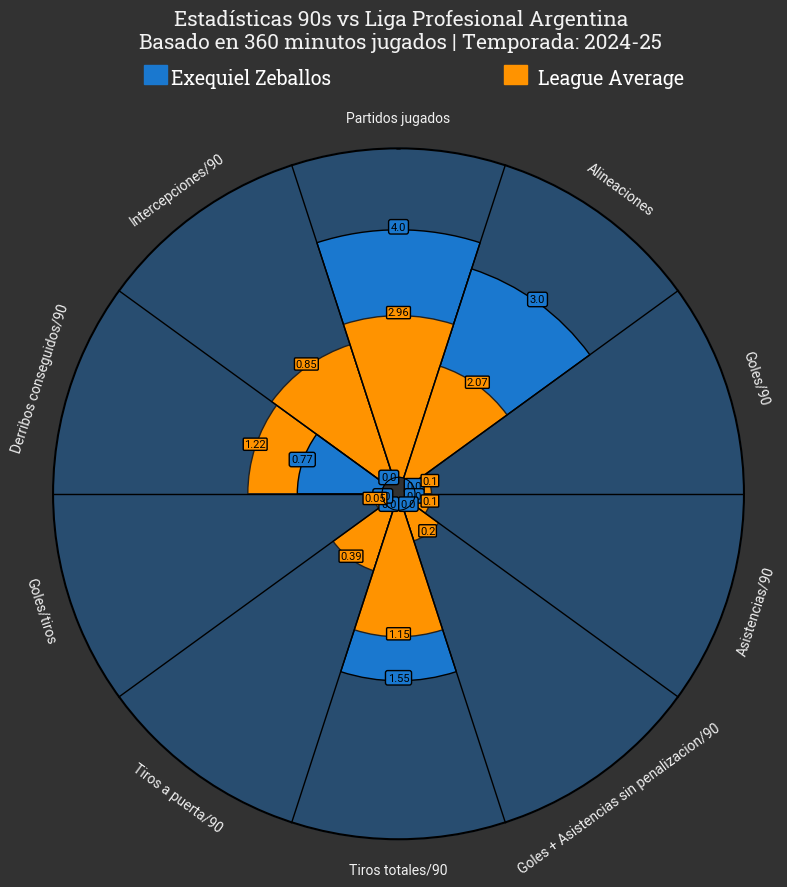

In [41]:
generar_pdf('https://fbref.com/en/players/02f9fb61/Exequiel-Zeballos')